In [4]:
import numpy as np
import plotfancy as pf
import matplotlib.pyplot as plt

pf.housestyle_rcparams()

import sys
sys.path.append('../../mist-base/GW')
import gw150814_simulator as gs

from gwpy.timeseries import TimeSeries
from scipy.signal import welch
from scipy.signal.windows import tukey

default = gs.defaults
default['posterior_samples_path'] = '../../mist-base/GW/GW150814_posterior_samples.npz'
default['f_max']=250

In [3]:
gw = gs.GW150814(settings=default)

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


True

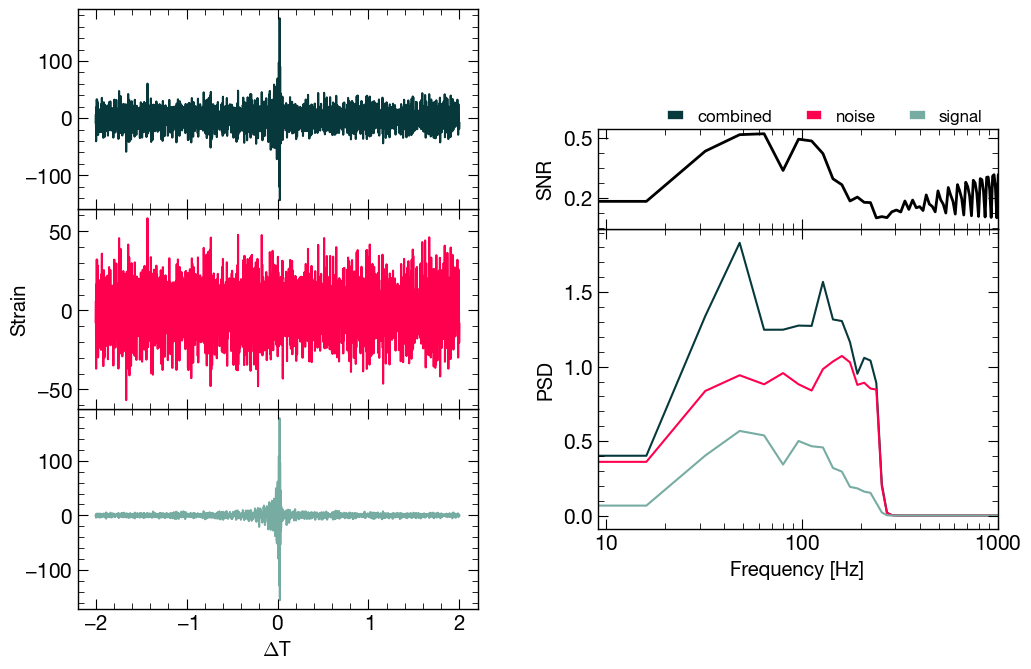

In [4]:
fig,ax1 = pf.create_plot(size=(4,2))
ax2 = fig.add_axes((0,1,1,1), sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)

tdw = gw.generate_time_domain_waveform()
tdn = gw.generate_time_domain_noise()

ax1.plot(gw.times, tdw, color='#77ACA2')
ax2.plot(gw.times, tdn, color='#ff004f')


ax1.set_xlabel(r'$\Delta$T')
ax2.set_ylabel(r'Strain')

###################

both = tdw + tdn

# gwosc_dat = np.real(gw.time_to_frequency_domain(data=gw.filter_gwosc_data()))

psd_sig = welch(tdw, window = 'tukey', fs = 1/gw.delta_t)
psd_noise = welch(tdn, window = 'tukey', fs = 1/gw.delta_t)
psd_both = welch(both, window = 'tukey', fs = 1/gw.delta_t)

####################

ax3 = fig.add_axes((0,2,1,1), sharex=ax1)
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.plot(gw.times, both, color='#07393C')

ax4 = fig.add_axes((1.3,0.4,1,1.5))
ax4.plot(psd_both[0], psd_both[1], color='#07393C', label='combined')
ax4.plot(psd_noise[0], psd_noise[1], color='#ff004f', label='noise')
ax4.plot(psd_sig[0], psd_sig[1], color='#77ACA2', label='signal')
ax4.set_xscale('log')
ax4.set_xlim([9,1000])
ax4.set_ylabel('PSD')
ax4.set_xlabel('Frequency [Hz]')

ax5 = fig.add_axes((1.3,1.9,1,0.5), sharex=ax4)
plt.setp(ax5.get_xticklabels(), visible=False)
ax5.plot(psd_sig[0], (psd_sig[1]/np.sqrt(psd_sig[1]**2+psd_noise[1]**2)), color='black', lw=2)
ax5.set_yticks([0.2,0.5])
ax5.set_ylabel('SNR')

ax4.legend(frameon=False, bbox_to_anchor = (1,1.3), loc='lower right', ncol=3)
pf.fix_plot([ax1,ax2,ax3,ax4,ax5])

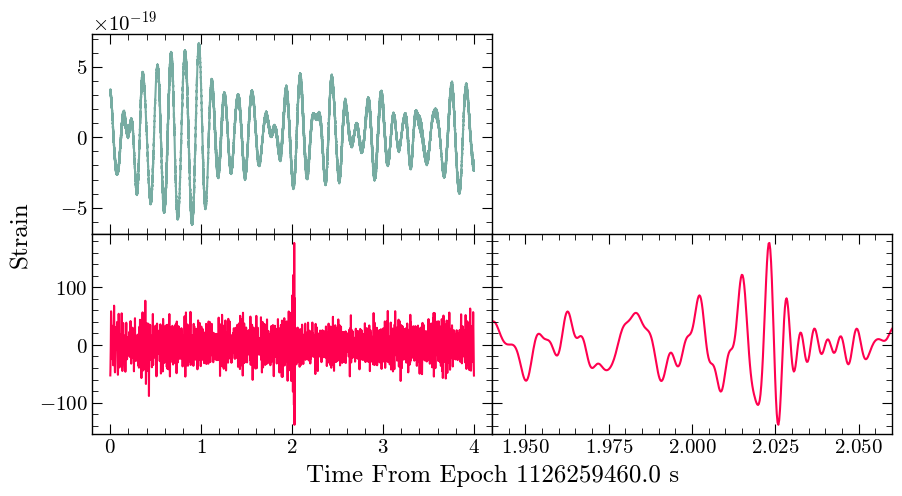

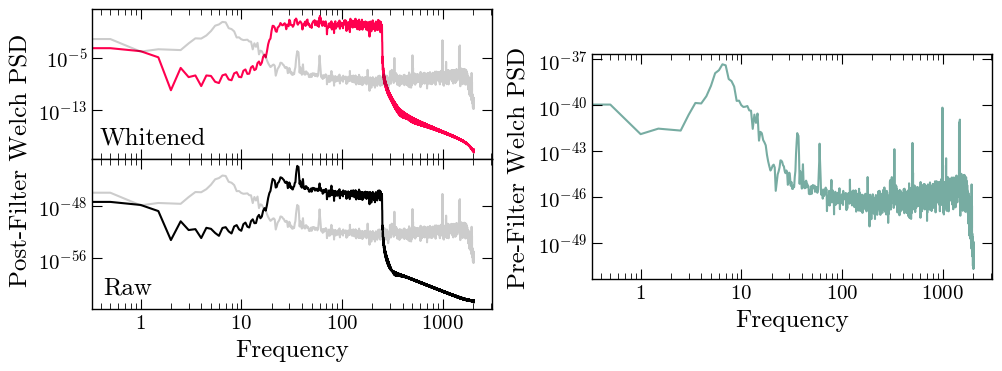

In [19]:
c = '#ff004f'
gwosc_dat = gw.data_gwosc
time_0 = gwosc_dat.dt * np.arange(len(gwosc_dat))
time_full = gwosc_dat.t0 + time_0

fig, ax1 = pf.create_plot((4,2))
plt.setp(ax1.get_xticklabels(), visible=False)
axes = [ax1]

ax1.plot(time_0,gwosc_dat,color='#77aca2')

####

ax2 = fig.add_axes((0,-1,1,1))
plt.setp(ax2.get_xticklabels(), visible=True)
axes.append(ax2)

ax2.plot(time_0,gw.filter_gwosc_data(), color=c)

ax3 = fig.add_axes((1,-1,1,1), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=True)
axes.append(ax3)

ax3.plot(time_0,gw.filter_gwosc_data(),color=c)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_xlim([1.94,2.06])

ax2.set_xlabel(f'Time From Epoch {np.round(gwosc_dat.t0)}')
ax2.set_ylabel(f'Strain')
ax2.xaxis.set_label_coords(1, -0.15)
ax2.yaxis.set_label_coords(-0.15, 1)


pf.fix_plot(axes)

####

def filter_notwhite(data):
    fd = np.fft.rfft(np.asarray(data))
    return np.fft.irfft(fd*data.filter())

def filter_notwhite(data):
    fd = data.fft()
    return data.fft(fd*data.filter())

def ttf(data):
        return (
            np.fft.rfft(np.array(data) * tukey(gw.npts, gw.tukey_alpha))
            * gw.delta_t)
    
def ftt(data):
        return np.fft.irfft(np.array(data)) / gw.delta_t

# gwosc_dat_fd = ttf(gwosc_dat)
# gwosc_dat_nwf = ftt(gwosc_dat_fd*gw.filter)

# ax2 = fig.add_axes((0,-1,1,1))
# plt.setp(ax2.get_xticklabels(), visible=True)
# axes.append(ax2)

# # ax2.plot(time_0,gw.filter_gwosc_data(), color=c)
# ax2.plot(time_0,gwosc_dat_nwf, color=c)


# ax3 = fig.add_axes((1,-1,1,1), sharey=ax2)
# plt.setp(ax3.get_xticklabels(), visible=True)
# axes.append(ax3)

# # ax3.plot(time_0,gw.filter_gwosc_data(),color=c)
# ax3.plot(time_0,gwosc_dat_nwf,color=c)

# plt.setp(ax3.get_yticklabels(), visible=False)
# ax3.set_xlim([1.94,2.06])

# ax2.set_xlabel(f'Time From Epoch {np.round(gwosc_dat.t0)}')
# ax2.set_ylabel(f'Strain')
# ax2.xaxis.set_label_coords(1, -0.15)
# ax2.yaxis.set_label_coords(-0.15, 1)

data_wf = welch(gw.filter_gwosc_data(), window = 'tukey', fs = 1/gw.delta_t, nperseg=8194)
gwosc_dat_fd = ttf(gwosc_dat)
gwosc_dat_nwf = ftt(gwosc_dat_fd*gw.filter)
data_nwf = welch(gwosc_dat_nwf, window = 'tukey', fs = 1/gw.delta_t, nperseg=8194)
gwosc_raw = welch(gwosc_dat, window = 'tukey', fs = 1/gw.delta_t, nperseg=8194)
gwosc_raw2 = gw.psd
plt.savefig(f'out/combo0.png',bbox_inches='tight', dpi=900)

fig2, bx = pf.create_plot(size=(4,1.5))
bxes = [bx]
bx.set_xscale('log')
bx.set_yscale('log')
bx.plot(data_wf[0], data_wf[1], color=c)
sf = data_wf[1][0]/gwosc_raw[1][0]
bx.plot(gwosc_raw[0], gwosc_raw[1]*sf, color='black', alpha=0.2)
bx.set_xlabel('Frequency')
bx.set_ylabel('Post-Filter Welch PSD')
bx.yaxis.set_label_coords(-0.15, 0)
bx.set_title('Whitened', y=.05, x=0.15)

bx1 = fig2.add_axes((0,-1,1,1),sharex=bx)
bxes.append(bx1)
bx1.plot(data_nwf[0], data_nwf[1], color='black')
sf = data_nwf[1][0]/gwosc_raw[1][0]
bx1.plot(gwosc_raw[0], gwosc_raw[1]*sf, color='black', alpha=0.2)
bx1.set_xscale('log')
bx1.set_yscale('log')
bx1.set_title('Raw', y=0.05, x=0.09)
bx1.set_xlabel('Frequency')

bx2 = fig2.add_axes((1.25,-.8,1,1.5),sharex=bx)
bxes.append(bx2)
bx2.set_ylabel('Pre-Filter Welch PSD')
bx2.plot(gwosc_raw[0], gwosc_raw[1], color='#77aca2')
bx2.set_yscale('log')
bx2.set_xlabel('Frequency')

pf.fix_plot(bxes)
plt.savefig(f'out/combo.png',bbox_inches='tight', dpi=900)

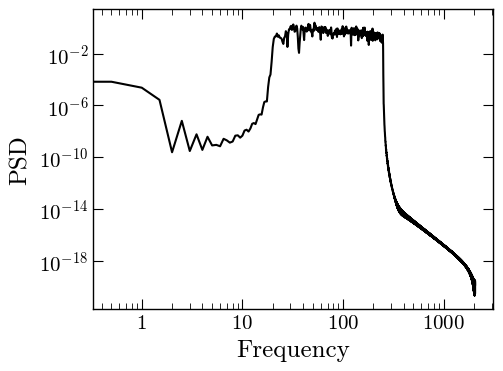

In [21]:
fig, cx = pf.create_plot(size=(4,3))
psd_sig = welch(tdw, window = 'tukey', fs = 1/gw.delta_t, nperseg=8194)
cx.loglog(psd_sig[0], psd_sig[1], color='black')
cx.set_xlabel('Frequency')
cx.set_ylabel('PSD')
pf.fix_plot([cx])
plt.savefig(f'out/GW_wf.png',bbox_inches='tight', dpi=900)

In [14]:
np.shape(psd_sig)

(2, 4098)